## Credit Card Fraud Detection Using GNNs

## Introduction

Fraud detection is the process of identifying and preventing unauthorized or suspicious activities, especially in industries like banking, finance, and e-commerce. In the context of credit card fraud detection, the goal is to identify fraudulent transactions while minimizing the impact on legitimate transactions. Given the financial and reputational risks involved, robust fraud detection systems are essential.


## Complex and evolving fraud patterns 

Fraudsters continually adapt their tactics, using sophisticated methods to evade detection. These often involve intricate networks of transactions designed to obscure fraudulent activities. Traditional rule-based systems and matrix-based machine learning models like SVMs and XGBoost typically analyze individual transactions (who transferred money to whom) but fail to capture the broader context of transaction patterns. Furthermore, rule-based systems require constant manual updates to keep up with emerging fraud strategies


## Challenges of Label Quality

One of the main challenges in credit card fraud detection is dealing with imbalanced and incompletely labeled datasets. Fraudulent transactions represent only a small fraction of total transactions. While domain experts label data points as either fraudulent or not, it is nearly impossible to identify all fraudulent instances, leading to noisy labels.

This class imbalance creates difficulties for supervised models, as training on imbalanced data often results in:

* **False negatives:** Fraudulent transactions misclassified as legitimate.

* **False positives:** Legitimate transactions wrongly flagged as fraud.

Graph Neural Networks (GNNs) address these issues by learning latent representations from transaction graphs and using them to identify hidden fraud patterns.


## Importance of Model Explainability

Simply predicting whether a transaction is fraudulent or not is insufficient, especially in sectors like banking, where transparency and accountability are crucial. It is important to explain why a model flagged a particular transaction as fraudulent. This allows investigators to:

* Understand how fraud occurs.

* Implement targeted anti-fraud measures.

* Ensure the model does not introduce biases.

Thus, fraud detection models must be interpretable, limiting the choice of models to those that balance predictive power with explainability.

## Graph-Based Approaches for Fraud Detection

Transactions can be naturally represented as a graph, where:

* Nodes represent users (credit card holders, merchants, etc.).

* Edges represent interactions (transactions between users).

Unlike traditional models that focus on node or edge features, graph-based methods leverage the graph structure, incorporating both local and global relationships between nodes.

In classic graph analytics, methods like the Louvain method and InfoMap help identify communities or clusters of users. However, these statistical methods often fail to capture dynamic or complex patterns.

Graph Neural Networks (GNNs) overcome this limitation by propagating information between nodes and edges through iterative message passing and aggregation. Multiple layers of graph convolution allow GNNs to capture long-range dependencies — essential for uncovering fraud chains that span multiple transactions

## Machine Learning on Graphs

The general pipeline for applying ML techniques to graphs involves the following steps:

* **Graph Representation:** Represent transactions as a graph using adjacency matrices, adjacency lists, or edge lists.

* **Feature Extraction:** Extract node and edge features such as transaction amounts, time intervals, or node degrees.

* **Dimensionality Reduction:** Apply techniques like PCA or t-SNE to reduce feature dimensionality, if needed.

* **Model Selection:** Choose suitable models like Graph Convolutional Networks (GCNs), Graph Attention Networks (GATs), or GraphSAGE.

* **Training and Evaluation:** Train models on labeled graph data and evaluate using metrics like precision, recall, and F1 score.

* **Prediction:** Use trained models to predict fraudulent nodes (users) or edges (transactions).

##  Step 1: Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# import networkx as nx
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

### Preprosessing 

Preprocessing tabular data before creating a graph is important because it ensures that the data is in a format that can be easily converted into a graph structure. Tabular data, such as a CSV file, typically contains rows and columns of information, with each row representing a single record and each column representing a specific feature or attribute. Before creating a graph, it is essential to clean and transform the data so that it is consistent and in a format that can be easily mapped to a graph structure. This may include tasks such as filling in missing values, converting data types, and removing duplicates.

Additionally, preprocessing tabular data can also help to improve the performance and accuracy of graph-based algorithms by reducing noise and irrelevant information in the data. This can be achieved by removing irrelevant features, normalizing numerical data, and encoding categorical data. Preprocessing can also help to balance the class distribution in case of imbalanced data, which is a common problem in fraud detection datasets.



In [2]:
os.chdir("../")
# Load the tabular dataset
df = pd.read_csv("artifacts/data_ingestion/credit_card_transactions.csv")

In [3]:
df

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,...,-112.4777,258,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0,NaN
1296671,1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,...,-77.5101,100,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0,22630.0
1296672,1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,...,-105.8189,899,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0,88351.0
1296673,1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,...,-102.5411,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0,69367.0


## Step 2: Data Overview

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from geopy.distance import geodesic

def create_extended_features(df):
    """Generates a wide range of features from the base columns."""

    # 1. Datetime Features
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['trans_year'] = df['trans_date_trans_time'].dt.year
    df['trans_month'] = df['trans_date_trans_time'].dt.month
    df['trans_day'] = df['trans_date_trans_time'].dt.day
    df['trans_hour'] = df['trans_date_trans_time'].dt.hour
    df['trans_minute'] = df['trans_date_trans_time'].dt.minute
    df['trans_second'] = df['trans_date_trans_time'].dt.second
    df['trans_dayofweek'] = df['trans_date_trans_time'].dt.dayofweek
    df['trans_timeofday'] = pd.cut(df['trans_hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)
    def get_season(month):
        if month in [3, 4, 5]: return 'Spring'
        elif month in [6, 7, 8]: return 'Summer'
        elif month in [9, 10, 11]: return 'Autumn'
        else: return 'Winter'
    df['trans_season'] = df['trans_month'].apply(get_season)

    # Cyclical features
    df['hour_sin'] = np.sin(2 * np.pi * df['trans_hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['trans_hour']/24)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['trans_dayofweek']/7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['trans_dayofweek']/7)

    # 2. Customer Features
    df['dob'] = pd.to_datetime(df['dob'])
    df['age'] = (df['trans_year'] - df['dob'].dt.year)
    df['customer_trans_count'] = df.groupby('cc_num')['trans_num'].transform('count')
    df['customer_avg_amt'] = df.groupby('cc_num')['amt'].transform('mean')
    df['customer_max_amt'] = df.groupby('cc_num')['amt'].transform('max')
    df['customer_min_amt'] = df.groupby('cc_num')['amt'].transform('min')
    df['customer_amt_std'] = df.groupby('cc_num')['amt'].transform('std').fillna(0)
    df['customer_last_trans_year'] = df.groupby('cc_num')['trans_year'].transform('max')

    # 3. Merchant Features
    df['merchant_avg_amt'] = df.groupby('merchant')['amt'].transform('mean')
    df['merchant_max_amt'] = df.groupby('merchant')['amt'].transform('max')
    df['merchant_min_amt'] = df.groupby('merchant')['amt'].transform('min')
    df['merchant_amt_std'] = df.groupby('merchant')['amt'].transform('std').fillna(0)

    # 4. Location-Based Features
    def calculate_distance(row):
        customer_coords = (row['lat'], row['long'])
        merchant_coords = (row['merch_lat'], row['merch_long'])
        return geodesic(customer_coords, merchant_coords).kilometers
    df['distance_customer_merchant'] = df.apply(calculate_distance, axis=1)
    df['amt_per_city_pop'] = df['amt'] / (df['city_pop'] + 1e-9)

    # 5. Transaction Features
    df['high_amt'] = (df['amt'] > df['customer_avg_amt'] + 3 * df['customer_amt_std']).astype(int)
    df['sqrt_amt'] = np.sqrt(df['amt'])
    df['amt_ratio_merchant'] = df['amt'] / (df['merchant_avg_amt'] + 1e-9)
    df['amt_diff_customer_avg'] = df['amt'] - df['customer_avg_amt']

    # 6. Interaction Features
    df['customer_merchant_count'] = df.groupby(['cc_num', 'merchant'])['trans_num'].transform('count')
    df['customer_category_count'] = df.groupby(['cc_num', 'category'])['trans_num'].transform('count')
    df['merchant_category_fraud_risk'] = df.groupby('category')['is_fraud'].transform('mean')

    # 7. Categorical Encoding
    le = LabelEncoder()
    df['category_encoded'] = le.fit_transform(df['category'])
    df['gender_encoded'] = df['gender'].map({'M': 1, 'F': 0})
    df['state_encoded'] = le.fit_transform(df['state'])
    df['timeofday_encoded'] = df['trans_timeofday'].map({'Night': 0, 'Morning': 1, 'Afternoon': 2, 'Evening': 3}).astype(int)
    df['season_encoded'] = df['trans_season'].map({'Spring': 0, 'Summer': 1, 'Autumn': 2, 'Winter': 3}).astype(int)

    return df

# Example usage
df = create_extended_features(df)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [8]:
import torch
from torch_geometric.data import HeteroData

# Load the HeteroData object from the file
data = torch.load("artifacts/graph_construction/graph_data.pt")

# Access the train_mask and test_mask from the 'transaction' node type
train_mask = data['transaction'].train_mask
test_mask = data['transaction'].test_mask

# Count the number of True values in train_mask and test_mask
num_train_true = torch.sum(train_mask).item()
num_test_true = torch.sum(test_mask).item()

# Check for intersection between train_mask and test_mask
intersection = torch.logical_and(train_mask, test_mask)
intersection_exists = torch.any(intersection).item()

# Print the results
print(f"Number of True values in train_mask: {num_train_true}")
print(f"Number of True values in test_mask: {num_test_true}")
print(f"Intersection between train_mask and test_mask exists: {intersection_exists}")

# Ensure that the intersection is always false.
assert not intersection_exists, "Train and test masks should not intersect."

print("Intersection check passed.")

Number of True values in train_mask: 1037340
Number of True values in test_mask: 259335
Intersection between train_mask and test_mask exists: False
Intersection check passed.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9300\1775164490.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("artifacts/graph_construction/graph_data.p

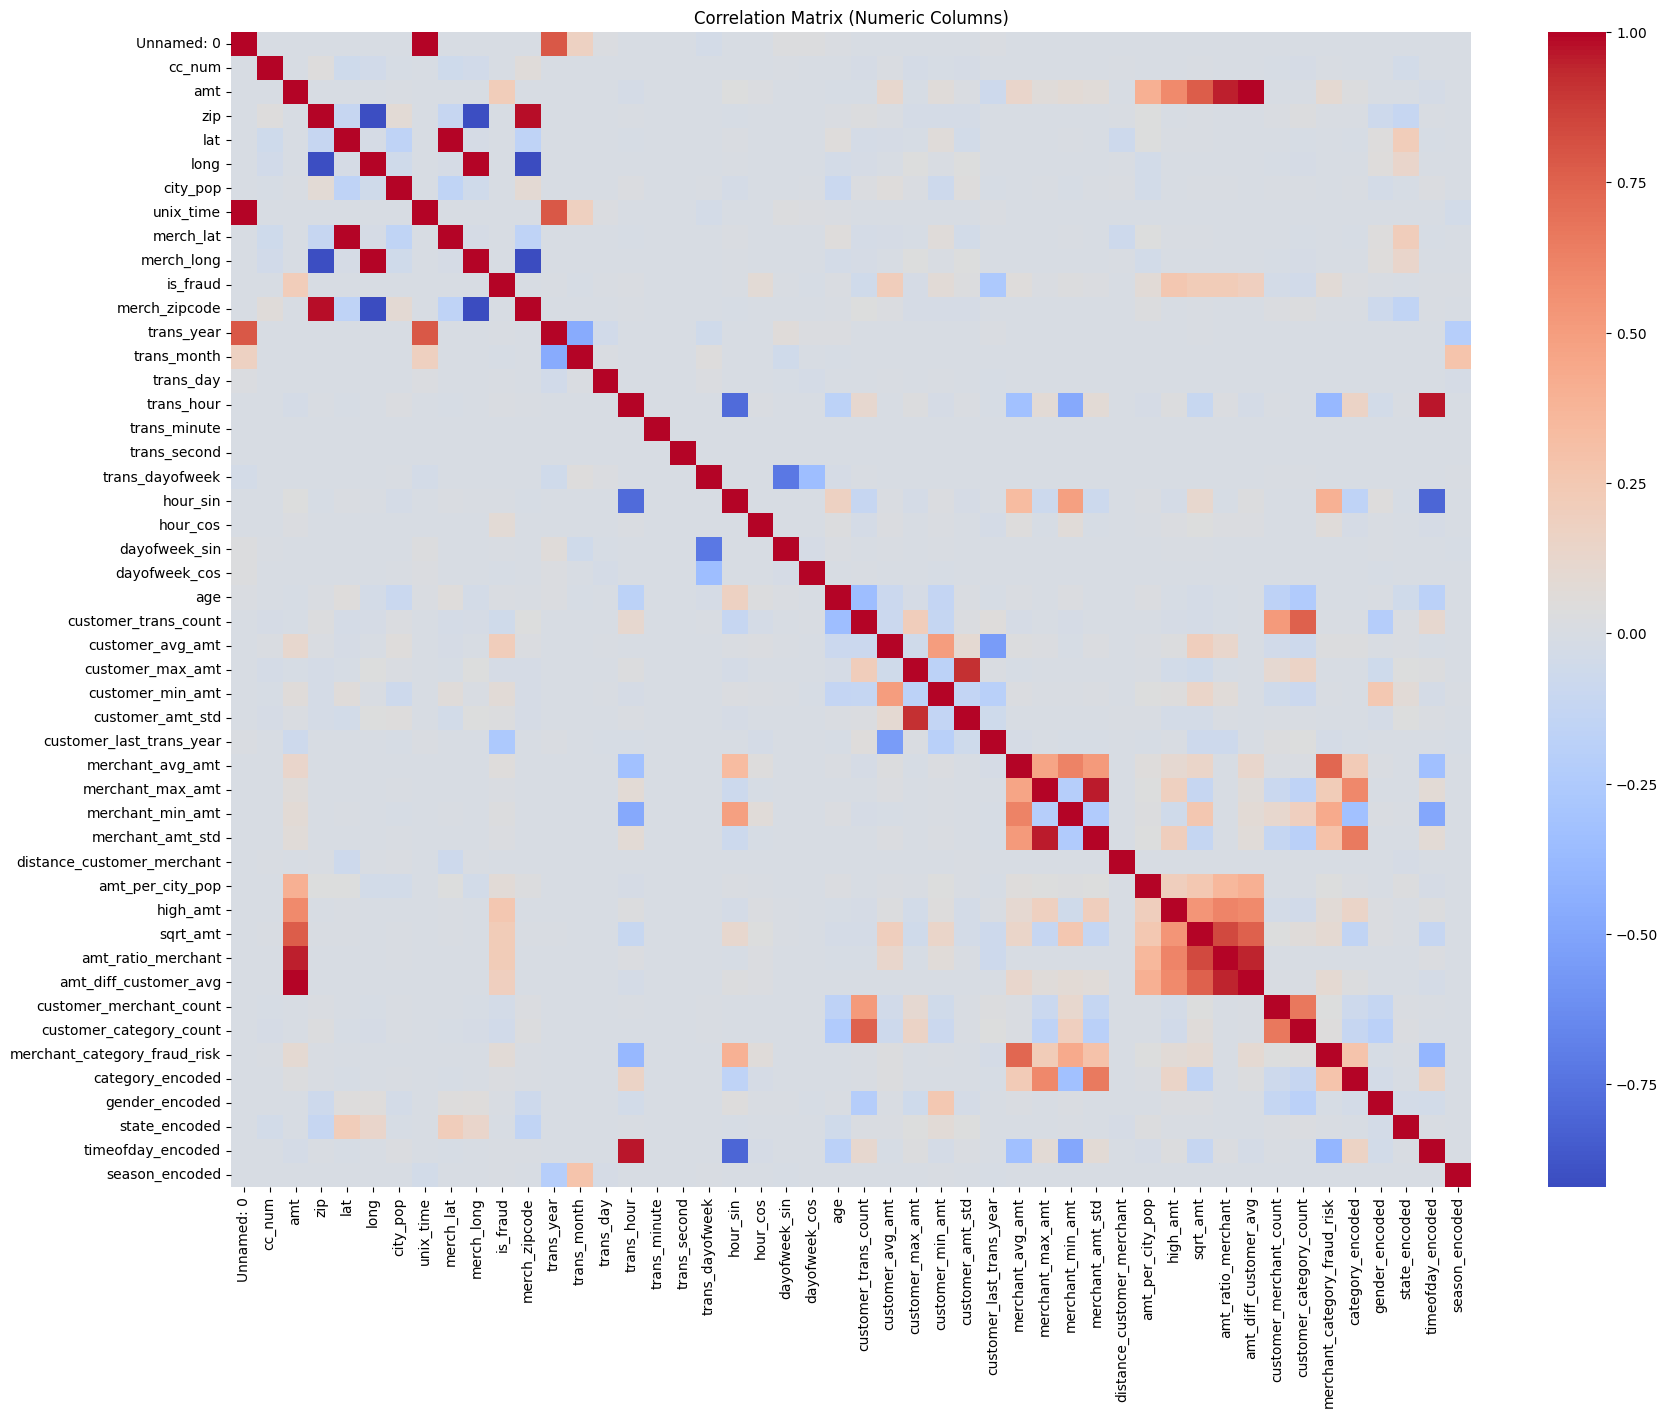

Top 15 numeric features correlated with is_fraud:
is_fraud                        1.000000
high_amt                        0.261607
amt_ratio_merchant              0.227010
sqrt_amt                        0.221949
amt                             0.219404
customer_avg_amt                0.209960
amt_diff_customer_avg           0.195421
hour_cos                        0.079343
amt_per_city_pop                0.074091
customer_min_amt                0.072140
merchant_category_fraud_risk    0.070725
merchant_avg_amt                0.052784
merchant_min_amt                0.030196
customer_amt_std                0.027645
merchant_amt_std                0.021005
Name: is_fraud, dtype: float64
   high_amt  amt_ratio_merchant   sqrt_amt     amt  customer_avg_amt  \
0         0            0.060407   2.229350    4.97         87.393215   
1         0            0.928835  10.355192  107.23         53.949320   
2         0            3.451419  14.836105  220.11         65.870040   
3         0     

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def create_numeric_correlation_matrix(df, target_column='is_fraud', top_n=15):
    """
    Creates a correlation matrix for numeric columns and displays the top N correlated features.

    Args:
        df (pd.DataFrame): The DataFrame containing features and target.
        target_column (str): The name of the target column.
        top_n (int): The number of top correlated features to display.
    """

    # Select only numeric columns
    numeric_df = df.select_dtypes(include=['number'])

    # Calculate correlation matrix
    correlation_matrix = numeric_df.corr()

    # Display correlation matrix (optional)
    plt.figure(figsize=(20, 15))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
    plt.title("Correlation Matrix (Numeric Columns)")
    plt.show()

    # Get correlations with the target column
    target_correlations = correlation_matrix[target_column].sort_values(ascending=False)

    # Display top N correlated features
    print(f"Top {top_n} numeric features correlated with {target_column}:")
    print(target_correlations.head(top_n))

    # Return top correlated columns (excluding target)
    top_correlated_columns = target_correlations.head(top_n + 1).index.tolist()
    if target_column in top_correlated_columns:
        top_correlated_columns.remove(target_column)

    return top_correlated_columns

def select_top_numeric_features(df, top_features):
    """
    Selects the top correlated numeric features from the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame.
        top_features (list): List of top correlated feature names.

    Returns:
        pd.DataFrame: DataFrame containing only the top numeric features and the target.
    """

    target_column = 'is_fraud'
    selected_df = df[top_features + [target_column]]
    return selected_df

# Example usage (assuming you have a DataFrame named 'df' and 'is_fraud' as your target)
top_numeric_features = create_numeric_correlation_matrix(df)
df_selected_numeric = select_top_numeric_features(df, top_numeric_features)
print(df_selected_numeric.head())

In [5]:
df["category"].unique()


array(['misc_net', 'grocery_pos', 'entertainment', 'gas_transport',
       'misc_pos', 'grocery_net', 'shopping_net', 'shopping_pos',
       'food_dining', 'personal_care', 'health_fitness', 'travel',
       'kids_pets', 'home'], dtype=object)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23],
 [Text(0, 0, 'merch_zipcode'),
  Text(1, 0, 'Unnamed: 0'),
  Text(2, 0, 'cc_num'),
  Text(3, 0, 'trans_date_trans_time'),
  Text(4, 0, 'category'),
  Text(5, 0, 'amt'),
  Text(6, 0, 'first'),
  Text(7, 0, 'merchant'),
  Text(8, 0, 'last'),
  Text(9, 0, 'gender'),
  Text(10, 0, 'city'),
  Text(11, 0, 'street'),
  Text(12, 0, 'zip'),
  Text(13, 0, 'lat'),
  Text(14, 0, 'long'),
  Text(15, 0, 'state'),
  Text(16, 0, 'city_pop'),
  Text(17, 0, 'job'),
  Text(18, 0, 'trans_num'),
  Text(19, 0, 'dob'),
  Text(20, 0, 'unix_time'),
  Text(21, 0, 'merch_lat'),
  Text(22, 0, 'merch_long'),
  Text(23, 0, 'is_fraud')])

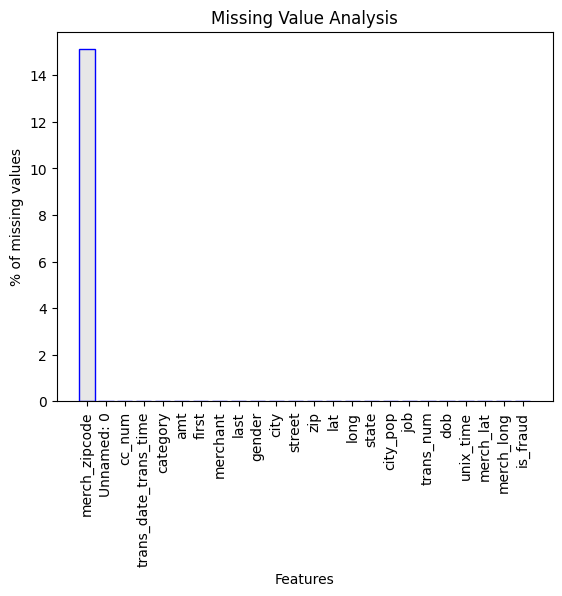

In [5]:
# Percentage of missing values
percent_missing=(df.isnull().sum()*100/df.shape[0]).sort_values(ascending=True)
plt.title("Missing Value Analysis")
plt.xlabel("Features")
plt.ylabel("% of missing values")
plt.bar(percent_missing.sort_values(ascending=False).index,percent_missing.sort_values(ascending=False),color=(0.1, 0.1, 0.1, 0.1),edgecolor='blue')
plt.xticks(rotation=90)

The card_id is defined as one card by one user. A specific user can have multiple cards, which would correspond to multiple different card_ids for this graph. 
For this reason we will create a new column which is the concatenation of the column User and the Column Card